# This notebook describes how Amoeba computes accretion disk transfer functions, surface flux distributions, and incorporates microlensing into each of these.

It is modular in the sense that components may be added or removed and the full model can be built up from pieces. Not all AGN exhibit the same features, and this should be reflected within the model. Please contact Henry Best at HBest@gradcenter.cuny.edu for assistance / bug reports.


Dependencies: Numpy, Astropy, Scipy, Matplotlib, skimage

Also: An external microlensing magnification map, which may be downloaded from the GERLUMPH database (https://gerlumph.swin.edu.au)


For GR ray tracing: Sim5




# Note, if you want to jump right in, please skip ahead [here](#my_classes) for a practical tutorial!

In [1]:
import numpy as np
import numpy.random as random
from astropy.io import fits
import astropy.constants as const
import astropy.units as u
from astropy.nddata import block_reduce
from scipy import signal
from scipy.interpolate import UnivariateSpline
import matplotlib.pyplot as plt
import sys
import time as supertime

sys.path.append("../src/")  # append path to where Amoeba is installed if elsewhere
from amoeba.Classes.accretion_disk import AccretionDisk
from amoeba.Classes.magnification_map import MagnificationMap
import amoeba.Util.util as util

example_disk_path = "../SampleDisks/RayTrace.fits"
example_mag_map_path = "/Users/henrybest/Downloads/output/map_3/map.bin"  # Insert a path to a magnification map (download seperate)

## This notebook aims to describe exactly how flux distributions and transfer functions are generated, so we will go through many details. For effective use, please skip down to "Classes".

First we will look at the dependence spin has on the ISCO, the innermost stable circular orbit within the Kerr metric.



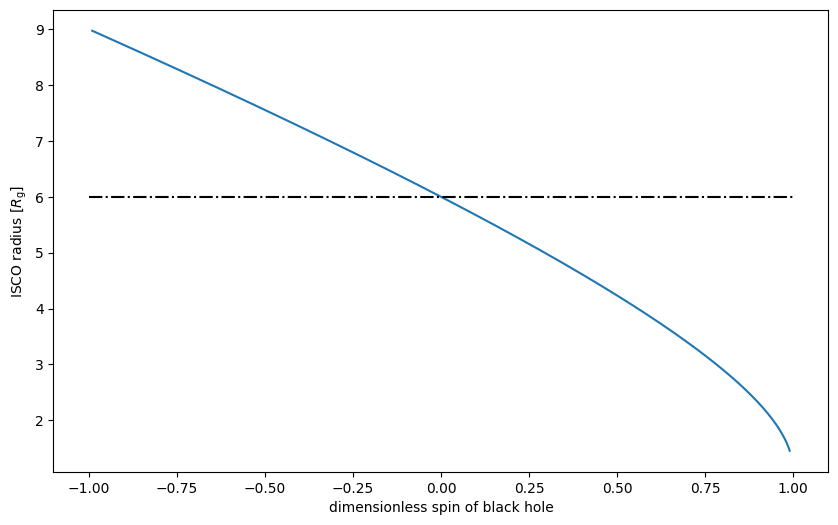

In [2]:
time_initial = supertime.time()  # timer to keep track of notebook run time


spins = np.linspace(-0.99, 0.99, 500)
r_isco = []
for spin in spins:
    r_isco.append(util.convert_spin_to_isco_radius(spin))

fig, ax = plt.subplots(figsize=(10, 6))
ax.plot(spins, r_isco)
ax.set_xlabel("dimensionless spin of black hole")
ax.set_ylabel(r"ISCO radius [$R_{\rm g}$]")
ax.plot([-1, 1], [6, 6], "-.", color="black")
plt.show()

The horizontal line represents the Schwarzschild case for a spinless black hole. Negative values of spin represent a black hole with angular momentum in the opposite direction with respect to the accreted material, while positive values of spin represent alligned angular momentum

Next is the convenience function "convert_eddington_ratio_to_accreted_mass", which calculates the accreted material in physical units under the assumption of a specified Eddington ratio with respect to the Eddington luminosity.

The Eddington luminosity is the theoretical limit which balances out gravitational pull against radiation pressure assuming protons are infalling via Bondi accretion. It is a convenient metric to describe accretion, but this is not a true limit. 

In [3]:
BH_mass_in_kg = 10**8.0 * const.M_sun.to(u.kg)
eddingtons = 0.15
accreted_material = util.convert_eddington_ratio_to_accreted_mass(
    BH_mass_in_kg, eddingtons, efficiency=0.1
)
print("Black hole mass = ", BH_mass_in_kg)
print("Eddington ratio = ", eddingtons)
print("Accreted material = ", accreted_material)
print(
    "or alternatively,",
    (accreted_material / const.M_sun.to(u.kg) * u.yr.to(u.s)).value,
    "M_sun / year",
)

Black hole mass =  1.988409870698051e+38 kg
Eddington ratio =  0.15
Accreted material =  2.098010464229376e+22 kg / s
or alternatively, 0.33297046047514295 M_sun / year


We see that about 1/3rd of a solar mass is required to be accreted per year to power the accretion disk at 10% of the Eddington limit for a $10^{8}$ solar mass black hole.

### Temperature profiles

Radial temperature profiles can be constructed using the "accretion_disk_temperature" function. The basic temperature profile is the Shakura-Sunyaev thin disk profile (Shakura+Sunyaev, 1973), and the function provided allows us to smoothly transition to both irradiated disk models (Cackett+ 2007) and disk wind models (Sun+ 2018). By default, a thin disk profile will be constructed. There are a few parameters:

radius_in_meters is the array of radial positions in meters.

min_radius_in_meters is the inner bound of the accretion disk in meters, usually taken to be the ISCO.

mass_in_solar_masses is the mass of the central black hole in solar masses.

eddington_ratio is the Eddington ratio, a proxy for the accreted mass by the accretion disk.

visc_temp_prof is the type of temperature profile to use. Currently supported are "SS" for Shakura-Sunyaev and "NT" for Novikov-Thorne.


Terms for the irradiated disk model are:

corona_height, the height of the central lamp post irradiating the accretion disk. This is assumed to be input in gravitational radii.

albedo, the reflectivity of the accretion disk with respect to irradiating x-ray sources. This is a dimensionless value between 0 and 1, where 0 is perfect absorption (leading to heating up the disk), and 1 is perfect reflection (no heat energy is transfered to the disk).

eta_x_rays, the efficiency of the x-ray emitter with respect to the Eddington luminosity. This parameter is essentially the Eddington ratio for the corona. 


Terms for the disk wind model are:

beta, the strength of the wind. In general, stronger winds are believed to remove material from the accreiton disk causing higher accretion rates further out in the disk than expected. 

generic_beta, a toggle if the user instead wishes to use beta as the asymptotic temperature slope instead of the wind parameter.




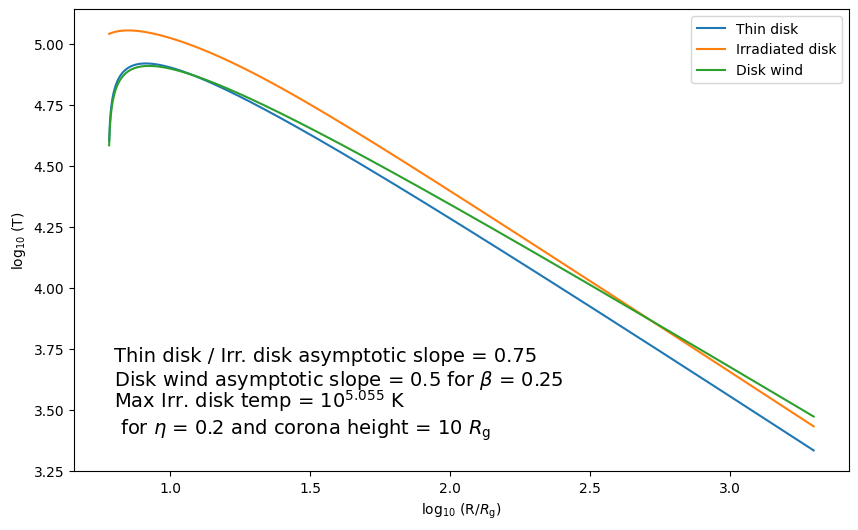

In [4]:
BH_mass_in_solar_masses = 10**8.0
grav_rad = util.calculate_gravitational_radius(BH_mass_in_solar_masses)
radii = np.linspace(1, 2000, 50000)
ISCO = 6 * grav_rad
beta = 0.25
lamp_height = 10
eta = 0.2

thindiskprofile = util.accretion_disk_temperature(
    radii * grav_rad, ISCO, BH_mass_in_solar_masses, 0.15
)

sample_irr_disk = util.accretion_disk_temperature(
    radii * grav_rad,
    ISCO,
    BH_mass_in_solar_masses,
    0.15,
    corona_height=lamp_height,
    albedo=0,
    eta_x_rays=eta,
)
sample_diskwind = util.accretion_disk_temperature(
    radii * grav_rad,
    ISCO,
    BH_mass_in_solar_masses,
    0.15,
    beta=beta,
)

fig, ax = plt.subplots(figsize=(10, 6))
ax.plot(np.log10(radii), np.log10(thindiskprofile), label="Thin disk")
ax.plot(np.log10(radii), np.log10(sample_irr_disk), label="Irradiated disk")
ax.plot(np.log10(radii), np.log10(sample_diskwind), label="Disk wind")
ax.set_xlabel(r"log$_{10}$ (R/$R_{\rm g}$)")
ax.set_ylabel(r"log$_{10}$ (T)")
ax.text(0.8, 3.7, "Thin disk / Irr. disk asymptotic slope = 0.75", fontsize=14)
ax.text(
    0.8,
    3.6,
    r"Disk wind asymptotic slope = "
    + str((3 - 4 * beta) / 4)
    + r" for $\beta$ = "
    + str(beta),
    fontsize=14,
)
ax.text(
    0.8,
    3.4,
    r"Max Irr. disk temp = 10$^{"
    + str(np.log10(np.max((sample_irr_disk))))[:5]
    + r"}$ K"
    + "\n"
    + r" for $\eta$ = "
    + str(eta)
    + " and corona height = "
    + str(lamp_height)
    + r" $R_{\rm g}$",
    fontsize=14,
)

plt.legend()
plt.show()

Due to the amount of parameters, this profile is quite flexible. 

The connection between temperature and luminosity is assumed to be black body radiation, given through the Planck formula. The function "planck_law" takes two inputs, a temperature in Kelvins, and a wavelength which is assumed to be in nanometers. This choice was made as it's convenient for UV, optical, and IR emissions, where the accretion disk tends to dominate the quasar's power.

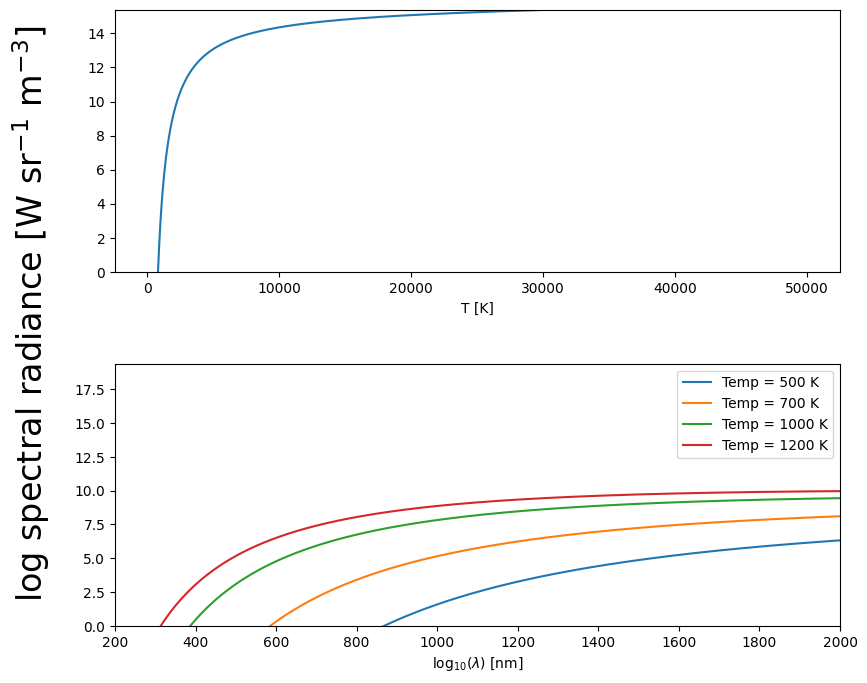

In [5]:
const_lam = 500
const_temp = 1200
maxlam = 20000

temperatures = np.linspace(1, 50000, int(1e6))
wavelengths = np.linspace(1, maxlam, int(1e6))
brightnesses = util.planck_law(temperatures, const_lam)
spectra500 = util.planck_law(500, wavelengths)
spectra700 = util.planck_law(700, wavelengths)
spectra1000 = util.planck_law(1000, wavelengths)
spectraconst = util.planck_law(const_temp, wavelengths)

fig, ax = plt.subplots(2, figsize=(10, 8))
ax[0].plot(temperatures, np.log10(brightnesses))
ax[1].plot(wavelengths, np.log10(spectra500), label="Temp = 500 K")
ax[1].plot(wavelengths, np.log10(spectra700), label="Temp = 700 K")
ax[1].plot(wavelengths, np.log10(spectra1000), label="Temp = 1000 K")
ax[1].plot(
    wavelengths, np.log10(spectraconst), label="Temp = " + str(const_temp) + " K"
)
ax[1].set_ylim(10 ** (-10), 2 * np.log10(np.max(spectraconst) / 2))
ax[0].set_ylim(10 ** (-10), np.log10(np.max(brightnesses) / 2))
ax[1].set_xlim(200, 2000)

ax[0].set_xlabel("T [K]")
ax[1].set_xlabel(r"log$_{10}(\lambda)$ [nm]")
# ax[0].text(
#    0, 0.8 * np.max(brightnesses), r"$\lambda$ = " + str(const_lam) + " nm", fontsize=16
# )
# ax[1].text(0.5*maxlam, 0.8*np.max(spectra1000), "Constant temp = "+str(const_temp)+" K", fontsize=16)
ax[1].legend()
fig.supylabel(r"log spectral radiance [W sr$^{-1}$ m$^{-3}$]", fontsize=24)
plt.subplots_adjust(hspace=0.35, right=0.85)
plt.show()

Note that these axes are on large scales, due to the radiance being calculated in MKS units. This is a flux density that passes through some solid angle. True fluxes will appear smaller as these are expressed per meter, as opposed to per nanometer or angstrom.

Planck's law will usually be applied to the accretion disk temperature profile, so we can combine the two to create a radial surface birghtness profile.

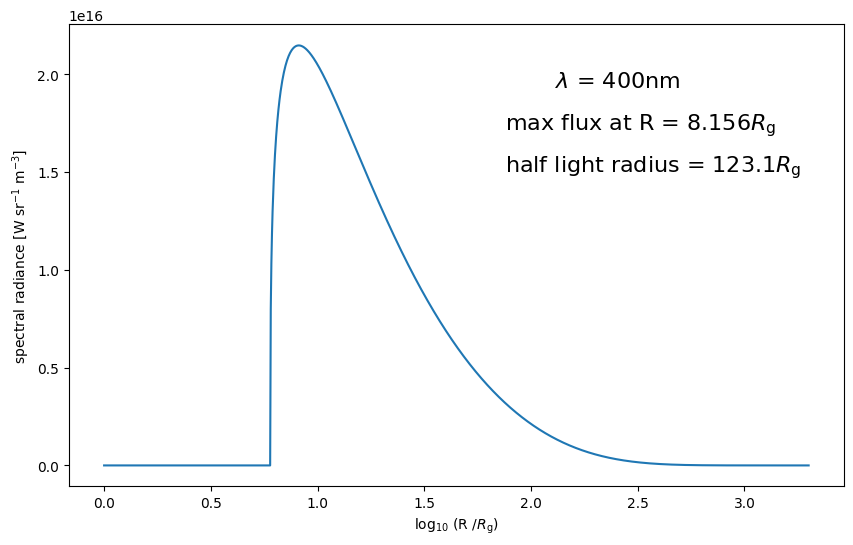

In [6]:
sim_wavelength = 400  # nm
temp_profile = thindiskprofile
sb_profile = util.planck_law(temp_profile, sim_wavelength)
half_rad = np.sum(radii * sb_profile) / 2
for kk in range(len(radii)):
    if np.sum(radii[:kk] * sb_profile[:kk]) > half_rad:
        index = kk
        break

fig, ax = plt.subplots(figsize=(10, 6))
ax.plot(np.log10(radii), sb_profile)
ax.text(
    0.45 * np.log10(len(radii)),
    0.9 * np.max(sb_profile),
    r"$\lambda$ = " + str(sim_wavelength) + r"nm",
    fontsize=16,
)
ax.text(
    0.4 * np.log10(len(radii)),
    0.8 * np.max(sb_profile),
    r"max flux at R = " + str(radii[np.argmax(sb_profile)])[:5] + r"$R_{\rm g}$",
    fontsize=16,
)
ax.text(
    0.4 * np.log10(len(radii)),
    0.7 * np.max(sb_profile),
    r"half light radius = " + str(radii[index])[:5] + r"$R_{\rm g}$",
    fontsize=16,
)
ax.set_xlabel(r"log$_{10}$ (R /$R_{\rm g}$)")
ax.set_ylabel("spectral radiance [W sr$^{-1}$ m$^{-3}$]")
plt.show()

The peak flux density will always peak at the point of maximum temperature, but the half light radius will depend on the wavelength evaluated at.

A value which is important for calculating the response of the disk by some external stimulus is the derivative of Planck's law. It is numerically calculated in the approximation that temperature is increased by 1 Kelvin, which is almost always a safe approximation for the effective temperatures of the accretion disk.

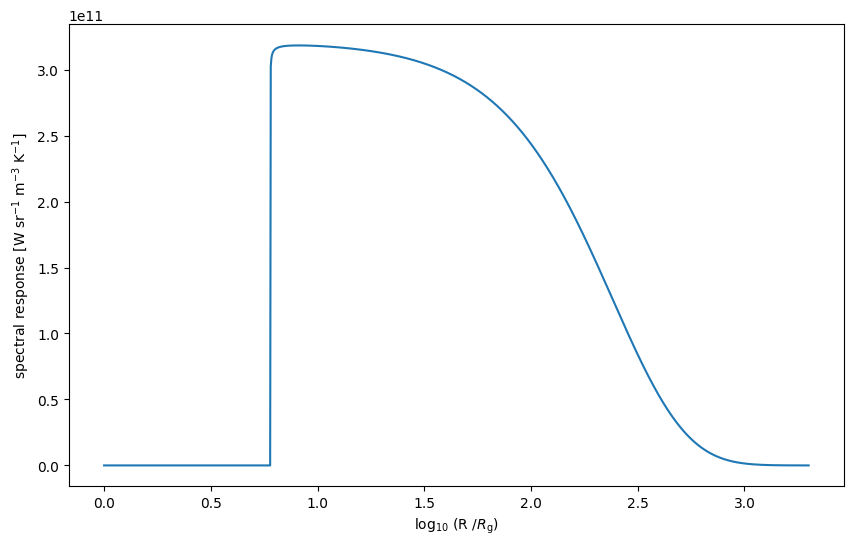

In [7]:
sim_wavelength = 400  # nm
temp_profile = thindiskprofile
sb_profile = util.planck_law_derivative(temp_profile, sim_wavelength)

fig, ax = plt.subplots(figsize=(10, 6))
ax.plot(np.log10(radii), sb_profile)
ax.set_xlabel(r"log$_{10}$ (R /$R_{\rm g}$)")
ax.set_ylabel("spectral response [W sr$^{-1}$ m$^{-3}$ K$^{-1}$]")
plt.show()

It is immediately apparent that this curve is wider for accretion disks than the spectral radiance, and will lead to the structure of response functions later in this notebook.

### Cosmological distances for microlensing

A few functions for calculating distances in flat cosmology are included, such as angular diameter distance, angular diameter distance difference, and luminosity distance. One classic example is the turnover for angular diameter distance.

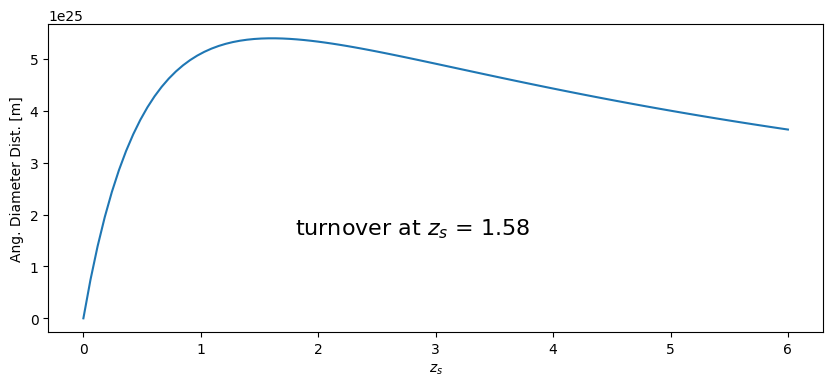

In [8]:
Omega_M = 0.3  # mass percentage of universe
H0 = 70

redshifts = np.linspace(0, 6, 100)
ang_diameters = np.zeros(np.shape(redshifts))
for rs in range(len(redshifts)):
    ang_diameters[rs] = util.calculate_angular_diameter_distance(
        redshifts[rs], OmM=Omega_M, H0=H0
    )


fig, ax = plt.subplots(figsize=(10, 4))
ax.plot(redshifts, ang_diameters)
ax.set_xlabel(r"$z_{s}$")
ax.set_ylabel("Ang. Diameter Dist. [m]")
ax.text(
    0.3 * np.max(redshifts),
    0.3 * np.max(ang_diameters),
    r"turnover at $z_{s}$ = " + str(round(redshifts[np.argmax(ang_diameters)], 2)),
    fontsize=16,
)
plt.show()

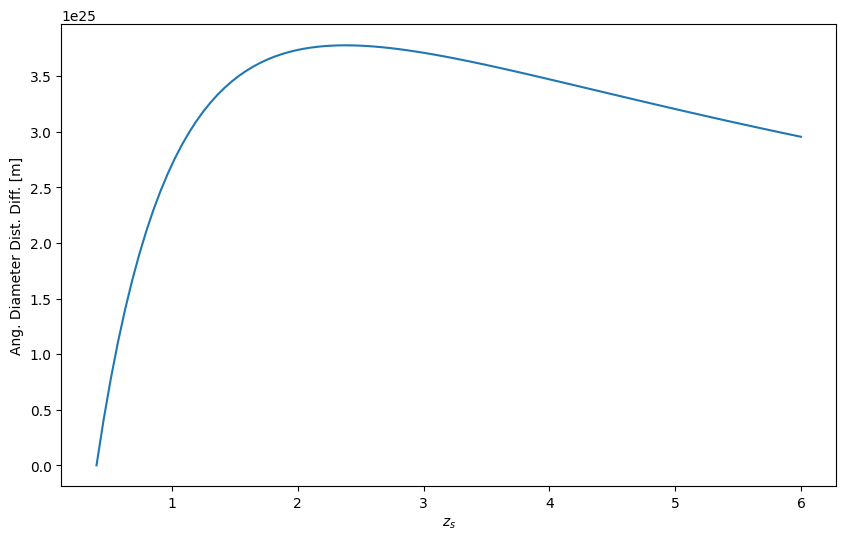

In [9]:
Omega_M = 0.3  # mass percentage of universe
H0 = 70
z1 = 0.4

redshifts = np.linspace(z1, 6, 100)
ang_dia_diffs = np.zeros(np.shape(redshifts))
for rs in range(len(redshifts)):
    ang_dia_diffs[rs] = util.calculate_angular_diameter_distance_difference(
        z1, redshifts[rs], OmM=Omega_M, H0=H0
    )


fig, ax = plt.subplots(figsize=(10, 6))
ax.plot(redshifts, ang_dia_diffs)
ax.set_xlabel(r"$z_{s}$")
ax.set_ylabel("Ang. Diameter Dist. Diff. [m]")
plt.show()

Luminosity distances can be used to scale emission simulations to cosmological distances

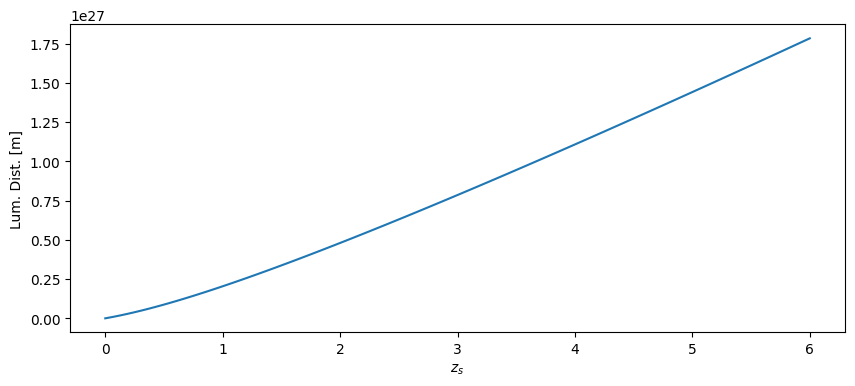

In [10]:
Omega_M = 0.3  # mass percentage of universe
H0 = 70

redshifts = np.linspace(0, 6, 100)
lum_dist = np.zeros(np.shape(redshifts))
for rs in range(len(redshifts)):
    lum_dist[rs] = util.calculate_luminosity_distance(redshifts[rs], OmM=Omega_M, H0=H0)


fig, ax = plt.subplots(figsize=(10, 4))
ax.plot(redshifts, lum_dist)
ax.set_xlabel(r"$z_{s}$")
ax.set_ylabel("Lum. Dist. [m]")
plt.show()

Unlike diameter distances, the luminosity distance does not have a turnover point. Further objects will always be dimmer, but not necessarily always smaller.

An important quantity in microlensing is the Einstein radius, which depends on the lens and source positions. Cosmology also effects this as the angular diameter distances are used.

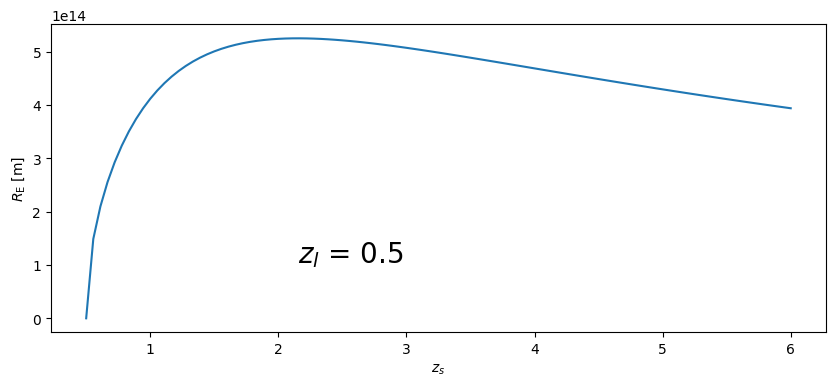

In [11]:
z_lens = 0.5
z_s = np.linspace(z_lens, 6, 100)
m_lens = const.M_sun.to(u.kg)

ein_rad = np.zeros(np.shape(z_s))
for rs in range(len(z_s)):
    ein_rad[rs] = util.calculate_einstein_radius_in_meters(
        z_lens, z_s[rs], mean_microlens_mass_in_kg=m_lens
    )

fig, ax = plt.subplots(figsize=(10, 4))
ax.plot(z_s, ein_rad)
ax.set_xlabel(r"$z_{s}$")
ax.set_ylabel(r"$R_{\rm E}$ [m]")
ax.text(
    0.3 * (np.max(z_s) - np.min(z_s)) + np.min(z_s),
    0.2 * np.max(ein_rad),
    r"$z_{l}$ = " + str(z_lens),
    fontsize=20,
)
plt.show()

Like with other angular diameter distances, this experiences a turnover as well. The Einstein radius determines the scale which microlensing probes most effectively at. 

### Accretion disk flux distributions and microlensing

We do not provide magnification maps in the source plane, so this must be obtained elsewhere through inverse ray shooting methods or other similar procedures. With the representative map of magnifications, we can explore the convolution between an accretion disk surface brightness image and the magnifications due to microlensing

Set up some surface brightness map

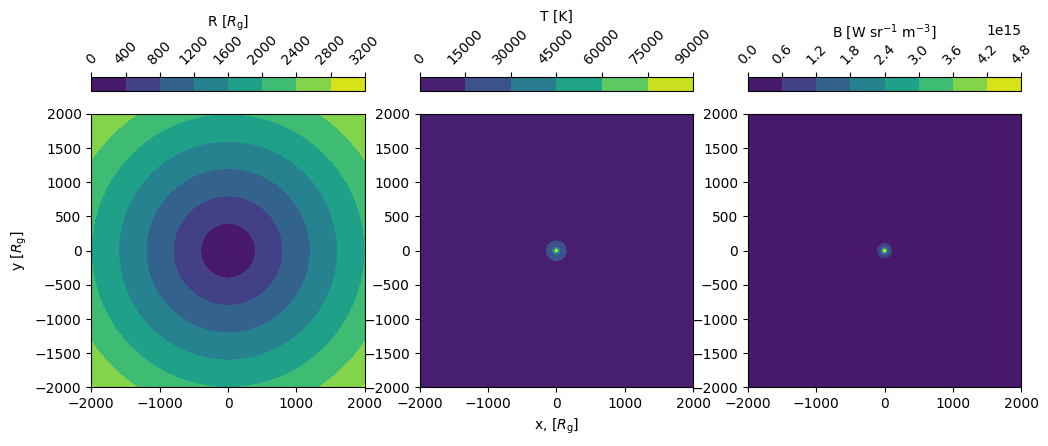

In [12]:
x = np.linspace(-2000, 2000, 2001)
y = np.linspace(-2000, 2000, 2001)
X, Y = np.meshgrid(x, y)
radii, phi_array = util.convert_cartesian_to_polar(X, Y)
mass_kg = 10**8.0 * const.M_sun.to(u.kg)
mass_sm = 10**8.0
grav_rad = util.calculate_gravitational_radius(mass_sm)
temp_map = util.accretion_disk_temperature(
    radii * grav_rad, 6 * grav_rad, mass_sm, 0.15
)
sb_map = util.planck_law(temp_map, 600)

fig, ax = plt.subplots(1, 3, figsize=(12, 6))
c1 = ax[0].contourf(X, Y, radii)
c2 = ax[1].contourf(X, Y, temp_map)
c3 = ax[2].contourf(X, Y, sb_map)
cbar1 = plt.colorbar(c1, ax=ax[0], location="top", label=r"R [$R_{\rm g}$]")
cbar2 = plt.colorbar(c2, ax=ax[1], location="top", label="T [K]")
cbar3 = plt.colorbar(c3, ax=ax[2], location="top", label=r"B [W sr$^{-1}$ m$^{-3}$]")
cbar1.ax.tick_params(rotation=45)
cbar2.ax.tick_params(rotation=45)
cbar3.ax.tick_params(rotation=45)
ax[0].set_ylabel(r"y [$R_{\rm g}$]")
ax[1].set_xlabel(r"x, [$R_{\rm g}$]")
for axis in ax:
    axis.set_aspect(1)
plt.show()

The first plot just illustrates the radial distances to all positions on the source plane. The second image shows a few contours of temperature, while the third image shows the spectral radiance of the disk around 600 nm which is proportional to observed flux.

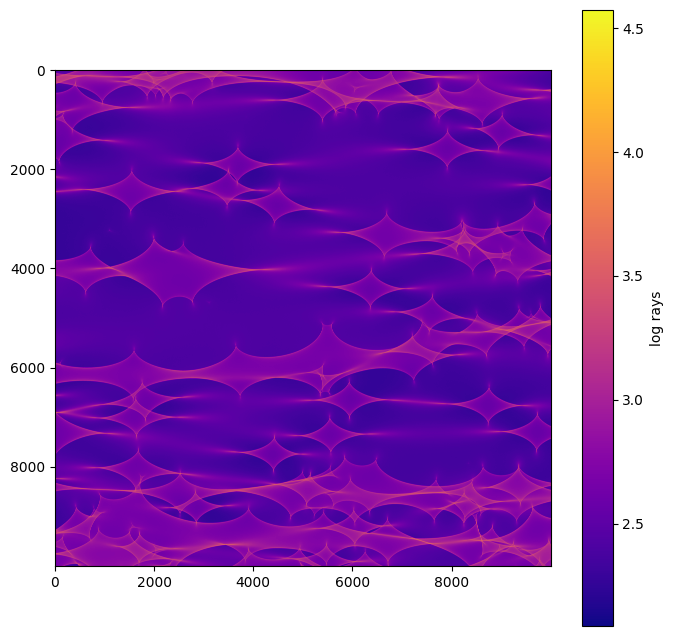

In [13]:
mag_map_path = example_mag_map_path
mag_map = np.fromfile(mag_map_path, dtype="int32")
n_pix_per_side = int(np.size(mag_map) ** 0.5)
mag_map_2d = np.reshape(mag_map, (n_pix_per_side, n_pix_per_side))

fig, ax = plt.subplots(figsize=(8, 8))
conts = ax.imshow(np.log10(mag_map_2d), cmap="plasma")
cbar = plt.colorbar(conts, ax=ax, label="log rays")
# magnification map image, contours are extremely thin so it's difficult to see by eye except on log scale
plt.show()

To perform the convolution, we should store our accretion disk and magnificaiton maps in their respective classes. The convolution may then be done using the MagnificationMap.convolve_with_flux_projection method. More information on classes follows.

In [14]:
z_s = 2.0
z_l = 0.5

Disk = AccretionDisk(
    smbh_mass_exp=8.0,
    redshift_source=z_s,
    inclination_angle=0,
    corona_height=lamp_height,
    temp_array=temp_map,
    phi_array=phi_array,
    g_array=np.ones(np.shape(temp_map)),
    radii_array=radii,
    height_array=np.zeros(np.shape(radii)),
)

disk_projection = Disk.calculate_surface_intensity_map(600)

MagMap = MagnificationMap(
    z_s,
    z_l,
    mag_map_2d,
    0.6,
    0.7,
)


convolution = MagMap.convolve_with_flux_projection(disk_projection)

The pixel sizes are :  1309755942387.5093 m
The pixel shift due to the convolution is :  225 pixels


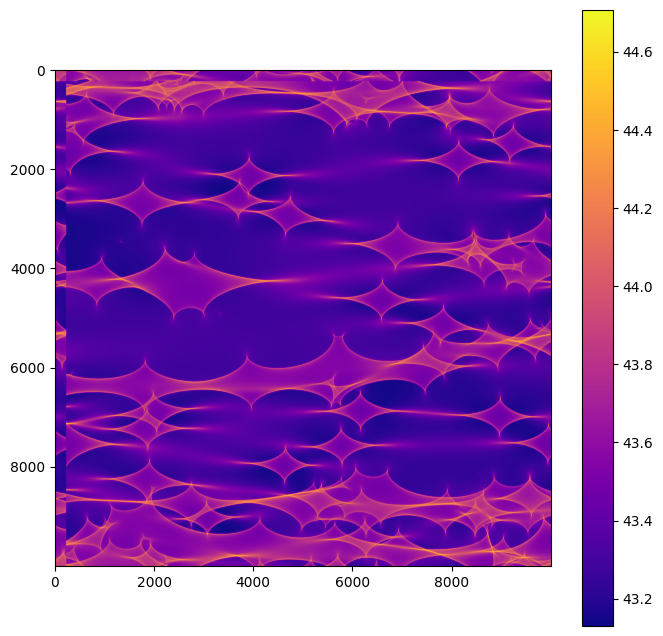

In [15]:
convolved_flux_map = convolution.magnification_array

print("The pixel sizes are : ", convolution.pixel_size, "m")
print("The pixel shift due to the convolution is : ", convolution.pixel_shift, "pixels")
fig, ax = plt.subplots(figsize=(8, 8))
conts = ax.imshow(np.log10(convolved_flux_map), cmap="plasma")
cbar = plt.colorbar(conts, ax=ax)

plt.show()

Depending on the size of the accretion disk, there is a region near the edges we must not use to avoid convolution artifacts (note the top and left edges). 

From this map, we can pull random light curves using PullLC function.

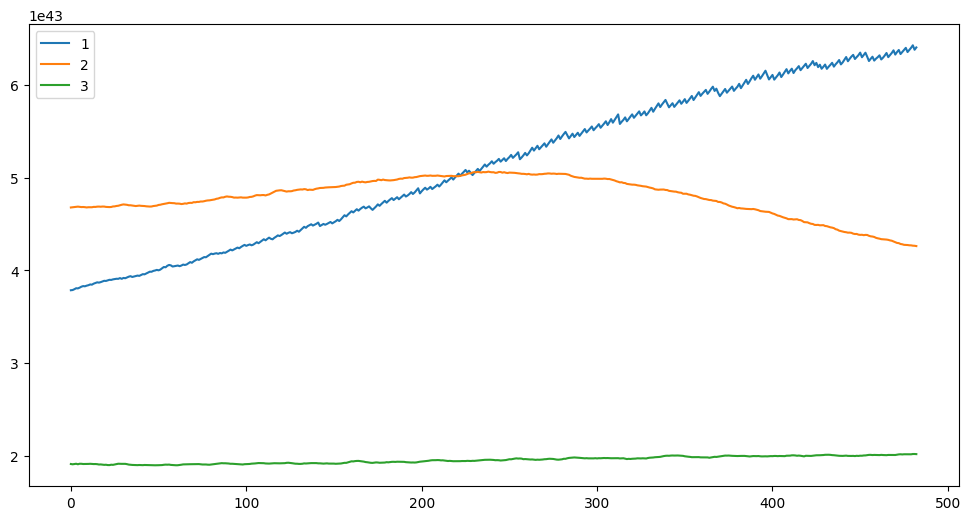

In [16]:
v_trans = 1000  # km/s in source plane
time = 20  # years
np.random.seed(2)  # for reproducibility

LCs = []
tracks = []

for jj in range(3):
    curve, tracks_x, tracks_y = convolution.pull_light_curve(
        v_trans, time, return_track_coords=True
    )
    LCs.append(curve)
    tracks.append([tracks_x, tracks_y])

fig, ax = plt.subplots(figsize=(12, 6))
for jj in range(len(LCs)):
    ax.plot(LCs[jj], label=str(jj + 1))
ax.legend()
plt.show()

We may plot the tracks on the convolution to see where they were drawn from

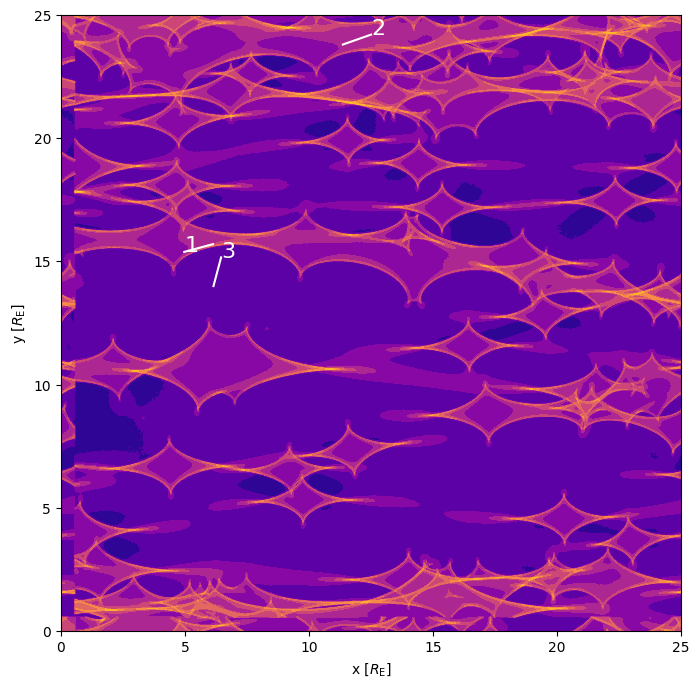

In [17]:
x = np.linspace(0, 25, 10000)  # Convert axes to units R_g
y = np.linspace(0, 25, 10000)
X, Y = np.meshgrid(x, y)

fig, ax = plt.subplots(figsize=(8, 8))
ax.contourf(X, Y, np.log10(convolution.magnification_array), cmap="plasma")
for jj in range(len(tracks)):
    ax.plot(tracks[jj][1] / 400, tracks[jj][0] / 400, color="white")
    ax.text(
        tracks[jj][1][0] / 400,
        tracks[jj][0][0] / 400,
        str(jj + 1),
        color="white",
        fontsize=16,
    )
ax.set_xlabel(r"x [$R_{\rm E}$]")
ax.set_ylabel(r"y [$R_{\rm E}$]")

plt.show()

## Transfer functions

Going back to the accretion disk itself, the lamp post model predicts time lags to be dominated by the light travel time between the x-ray source and the accretion disk. This may be extended to any source of additional flux which may heat up the accretion disk, i.e. a magnetic recombination flare in plasma, an unstable jet base, etc. 

The function calculate_time_lag_array allows for the creation of a time lag map from any point above the accretion disk to the accretion disk. 


The arguments are as follows:

radii_array is a 2d array in gravitational radii.

phi_array is a 2d array of azimuth angles defined such that the negative y axis is toward the observer.

inclination_angle is the inclination of the disk in degrees.

corona_height is the height of the lamppost in gravitational radii.

axis_offset_in_gravitational_radii is an offset from the axis of symmetry for the lamppost's position in gravitational radii.

angle_offset_in_degrees is an azimuth offset for the lamppost's position.

height_array is a 2d array of heights representing where we are computing the time lag to.


(2001, 2001)


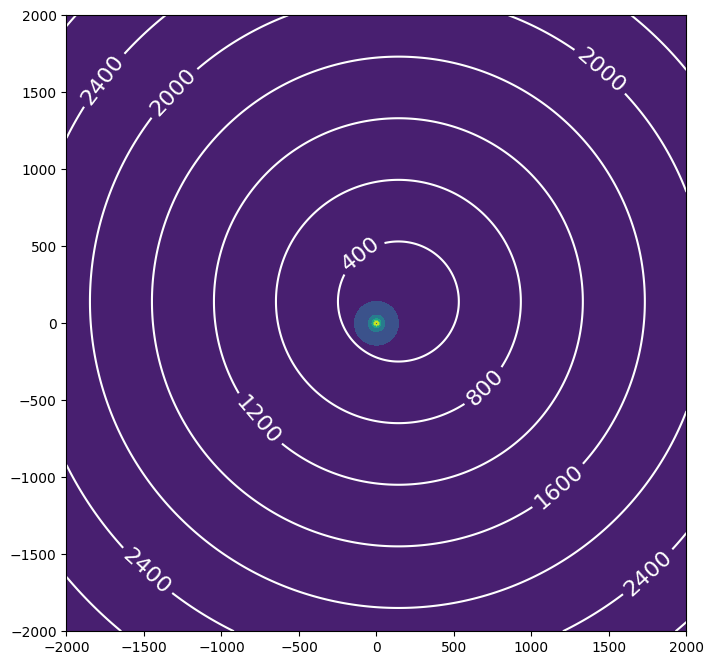

In [18]:
time_delays = util.calculate_time_lag_array(
    radii,
    phi_array,
    0,
    corona_height=10,
    axis_offset_in_gravitational_radii=200,
    angle_offset_in_degrees=45,
)  # note axis offset!

print(np.shape(phi_array))
x = np.linspace(-2000, 2000, 2001)
y = np.linspace(-2000, 2000, 2001)
X, Y = np.meshgrid(x, y)
fig, ax = plt.subplots(figsize=(8, 8))
ax.contourf(X, Y, temp_map)
delays = ax.contour(X, Y, time_delays, colors="white")
plt.clabel(delays, inline=1, fontsize=16)
plt.show()

calculate_geometric_disk_factor is a function which calculates the geometric coefficient in the lamppost model. This is defined as (1 - A) cos(theta_x) / (4 * pi * sigma_sb * R_{lamppost}^{2}). If we assume the same functional form which connects the lamp post to the heating of the disk, this term can be extended to be used with any other flaring event beyond the lamp post model including those described in the time delay map description above.

This function takes the following arguments:

temp_array is the temperature of the accretion disk at all positions in Kelvins.

radii_array is the radius in gravitational radii.

phi_array is the azimuth angle as described previously.

smbh_mass_exponent is the solution of log_10(M/M_{sun}).

corona_height is the height of the lamppost in gravitational radii.

axis_offset_in_gravitational_radii is an offset from the axis of symmetry for the lamppost's position in gravitational radii.

angle_offset_in_degrees is an azimuth offset for the lamppost's position.

height_array is a 2d array of heights representing where we are computing the time lag to. Note this is still experimental at this point!

albedo_array is a 2d array of albedo values, allowing for non-uniform absorption by the accretion disk.


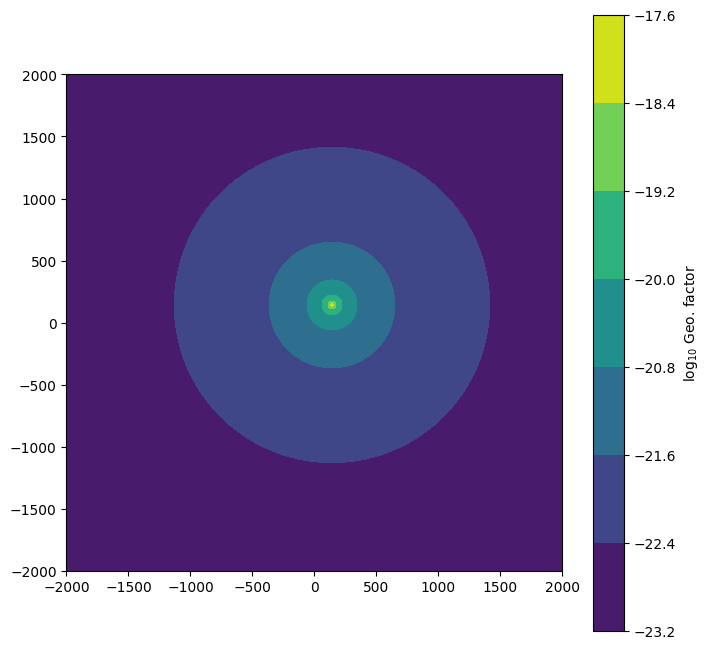

In [19]:
disk_factor = util.calculate_geometric_disk_factor(
    temp_map,
    radii,
    phi_array,
    8.0,
    5,
    axis_offset_in_gravitational_radii=200,
    angle_offset_in_degrees=45,
)
fig, ax = plt.subplots(figsize=(8, 8))
conts = ax.contourf(X, Y, np.log10(disk_factor.value))
cbar = plt.colorbar(conts, ax=ax, label=r"log$_{10}$ Geo. factor")
ax.set_aspect(1)
plt.show()

For the case of the lamp post illuminator, the geometric factor above scales the x-ray luminosity. Under the assumption any other illuminator acts the same way, the geometric factor should remain identical and this can be used at any other position.

The function "calculate_dt_dlx" calculates the rate of change in temperature with respect to illumination from the x-ray source

its arguments are identical to calculate_geometric_disk_factor.

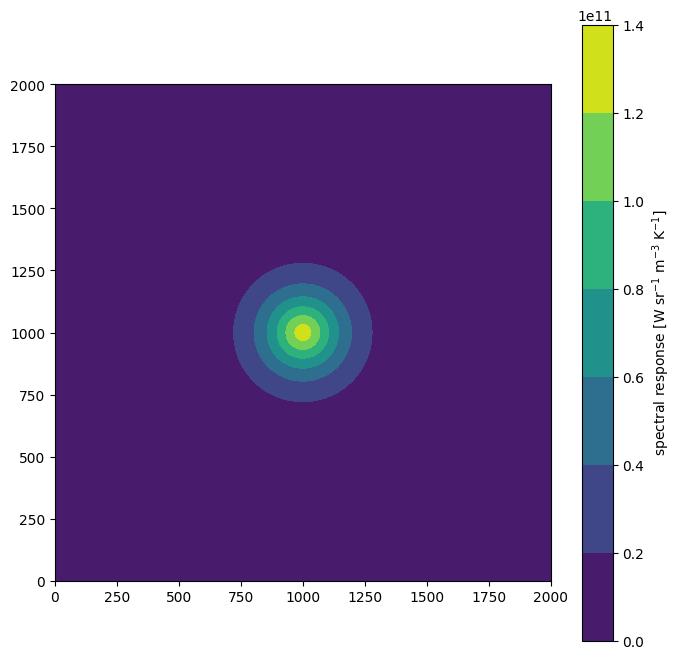

In [20]:
lam = 500
disk_deriv = util.planck_law_derivative(temp_map, lam)

fig, ax = plt.subplots(figsize=(8, 8))
conts = ax.contourf(disk_deriv)
plt.colorbar(conts, ax=ax, label="spectral response [W sr$^{-1}$ m$^{-3}$ K$^{-1}$]")
ax.set_aspect(1)
plt.show()

Combining all of the above, we can construct the transfer function which connects the driving source to the accretion disk's response. This is the kernel between some impulse at a position above the disk and the disk's response, and is wavelength dependent.


construct_accretion_disk_transfer_function has the following arguments:

rest_wavelength_in_nm is the wavelength in nanometers which we are computing the transfer function of.

temp_array, radii_array, phi_array are the temperature, radii, and azimuths of the accretion disk, respectively.

g_array is a 2d array of relativistic redshifts.

inclination_angle is the inclination of the accretion disk in degrees.

corona_height is the height of the lamppost in gravitational radii.

axis_offset_in_gravitational_radii is an offset from the axis of symmetry for the lamppost's position in gravitational radii.

angle_offset_in_degrees is an azimuth offset for the lamppost's position.

height_array is a 2d array of heights representing where we are computing the time lag to. Note this is still experimental at this point!

albedo_array is a 2d array of albedo values, allowing for non-uniform absorption by the accretion disk.

return_response_array_and_lags is a boolean to return the 2d distributions of the surface response and the time delays.

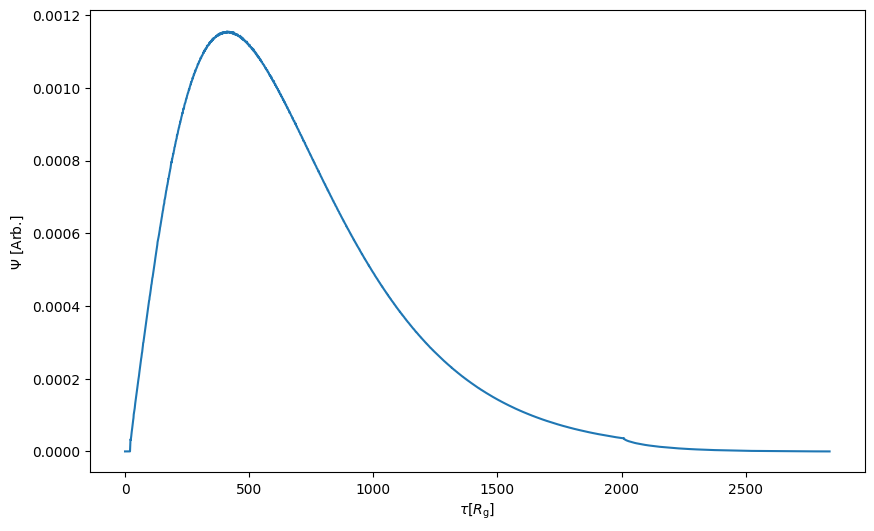

In [21]:
cheight = 20

basic_transfer_function = util.construct_accretion_disk_transfer_function(
    600, temp_map, radii, phi_array, np.ones(np.shape(radii)), 0, 8.0, lamp_height
)

fig, ax = plt.subplots(figsize=(10, 6))
ax.plot(basic_transfer_function)
ax.set_xlabel(r"$\tau [R_{\rm{g}}]$")
ax.set_ylabel(r"$\Psi$ [Arb.]")
plt.show()

The transfer function generally features an initial time lag, which depends on how far light must travel down to the accretion disk before being reprocessed and coming back to the observer. Then this is followed by a steep rise when the source is on the central axis. It generally trails off slowly, and sometimes may be truncated due to the disk not being calculated to infinity.

Inclined accretion disks tend to have skewed transfer functions, and the midpoint may change if the source height is significantly above the disk. For sources approximately on the same level of the disk, the mean time lag will not be effected by orientation.

The "calculate_microlensed_transfer_function" function essentially combines the creation of a transfer function with the amplified response due to a static microlensing map. It has the following additional arguments:

magnification_array, the magnification map due to microlensing

redshift_lens, the redshift of the gravitational lens.

redshift_source, the redshift of the AGN.

mean_microlens_mass_in_kg, the average microlens mass in kg.

number_of_microlens_einstein_radii, the size of the magnification array in the microlens' einstein radii.

number_of_smbh_gravitational_radii, the size of the agn flux map in smbh gravitational radii.

relative_orientation, the relative angle between the AGN and the microlensing map.

return_descaled_response_array_and_lags, a boolean toggle to return the 2d response arrays and time lags. Useful to test if the magnification map is causing resolution issues.

In [22]:
my_disk = AccretionDisk(
    smbh_mass_exp=8.0,
    redshift_source=0.1,
    inclination_angle=0,
    corona_height=lamp_height,
    temp_array=temp_map,
    phi_array=phi_array,
    g_array=np.ones(np.shape(temp_map)),
    radii_array=radii,
)
MagMap = MagnificationMap(0.1, 0.05, mag_map_2d, 0.6, 0.7)

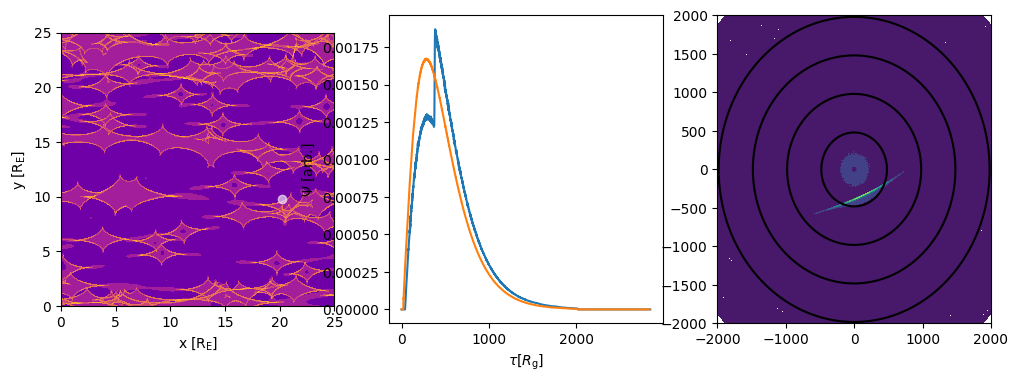

In [23]:
wavelength = 500
cheight = 20
random_seed = 457

### Note that numpy arrays use (y, x) coordinates. This is why when plotting the black hole's position on subplot[0], we use signature (y, x).
mag_response, delays, x_po, y_po = MagMap.calculate_microlensed_transfer_function(
    my_disk, wavelength, corona_height=cheight, return_response_array_and_lags=True, random_seed=random_seed
)
microlensed_response = MagMap.calculate_microlensed_transfer_function(
    my_disk,
    wavelength,
    corona_height=cheight,
    x_position=x_po,
    y_position=y_po
)
delta_x = np.size(mag_response)

basic_transfer_function = my_disk.construct_accretion_disk_transfer_function(wavelength)

x = np.linspace(0, 25, 10000)
y = np.linspace(0, 25, 10000)
X, Y = np.meshgrid(x, y)

fig, ax = plt.subplots(1, 3, figsize=(12, 4))
ax[0].contourf(X, Y, np.log10(MagMap.magnification_array), cmap="plasma")
ax[0].plot((y_po) / 400, (x_po) / 400, "o", color="white", alpha=0.6)
ax[0].set_xlabel(r"x [R$_{\rm E}$]")
ax[0].set_ylabel(r"y [R$_{\rm E}$]")
ax[0].set_aspect(1)

ax[1].plot(microlensed_response)
ax[1].plot(basic_transfer_function)
ax[1].set_xlabel(r"$\tau [R_{\rm{g}}]$")
ax[1].set_ylabel(r"$\Psi$ [arb.]")

x_ax_disk = np.linspace(-my_disk.r_out_in_gravitational_radii, my_disk.r_out_in_gravitational_radii, np.size(mag_response, 0))
diskx, disky = np.meshgrid(x_ax_disk, x_ax_disk)
ax[2].contourf(diskx, disky, (mag_response))
ax[2].contour(diskx, disky, delays, [500, 1000, 1500, 2000], colors='black')
plt.show()

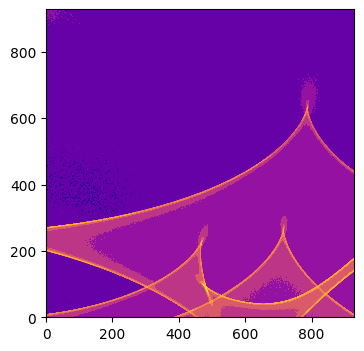

In [24]:
my_crop = MagMap.calculate_microlensed_transfer_function(
    my_disk,
    wavelength,
    corona_height=cheight,
    x_position=x_po,
    y_position=y_po,
    return_magnification_map_crop=True
)
fig, ax = plt.subplots(figsize=(5, 4))
ax.contourf(np.log10(my_crop), cmap="plasma")
ax.set_aspect(1)
plt.show()

Here, the left plot shows the magnification map with a white dot located where the transfer function is calculated at. In right is the response in blue, with the unmicrolensed case in orange. Microlensing may have a significant impact on the shape, mean, and centroid of the transfer function. 

Note that scaling the pixels of the accretion disk image to the pixel sizes of the magnification map may introduce a slight shift in the transfer function.

### Stochastic signals

The next couple functions are a few conveinence functions, generate_drw_signal creates a generic damped random walk signal given parameters:

length_of_light_curve, the length of the light curve to generate.

time_step, the spacing between points of the light curve.

sf_infinity, the asymptotic structure function value.

tau_drw, the characteristic time scale.

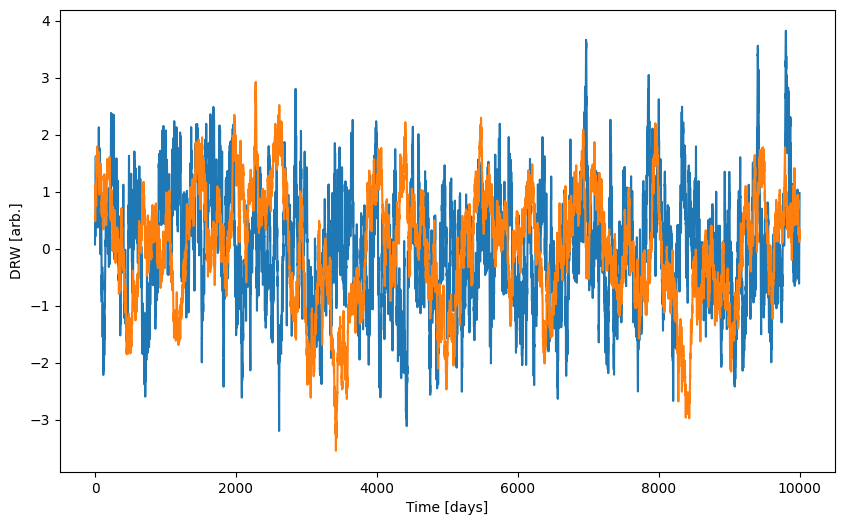

In [25]:
t_max = 10000  # years, by default
delta_t = 1  # days, by default
SF_inf = 20
tau = 30  # Days, by default
np.random.seed(3)

DRW = util.generate_drw_signal(t_max, delta_t, SF_inf, tau)
DRW2 = util.generate_drw_signal(t_max, delta_t, SF_inf, tau * 4)

fig, ax = plt.subplots(figsize=(10, 6))
ax.plot(DRW)
ax.plot(DRW2)
ax.set_xlabel("Time [days]")
ax.set_ylabel("DRW [arb.]")
plt.show()

Now let's take the source plane signal and convolve it with a transfer function, then bring into the observer frame.

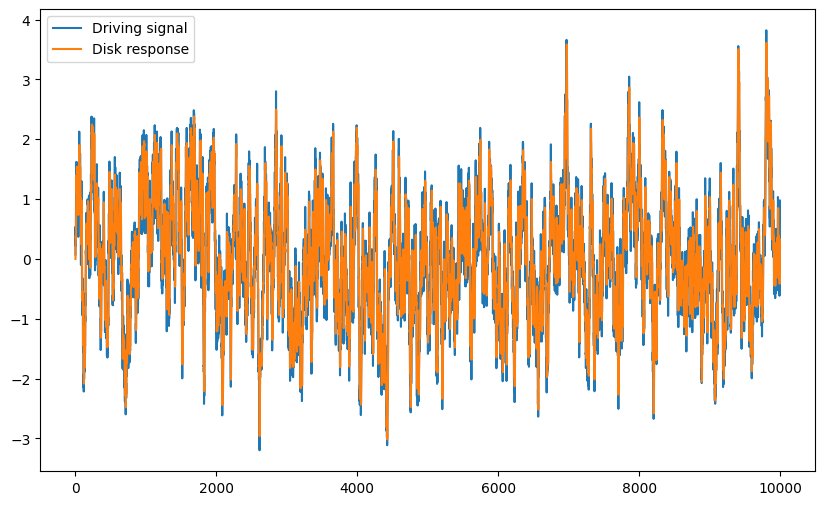

In [26]:
timestamps = np.linspace(0, t_max, int(t_max / delta_t) + 1)

new_timestamps, signal_convolved = util.convolve_signal_with_transfer_function(
    smbh_mass_exp=8.0,
    driving_signal=DRW,
    transfer_function=basic_transfer_function,
    initial_time_axis=timestamps,
)


fig, ax = plt.subplots(figsize=(10, 6))
ax.plot(timestamps, DRW, label="Driving signal")
ax.plot(
    new_timestamps, signal_convolved / np.std(signal_convolved), label="Disk response"
)
# Zoom in to show impact
# ax.set_xlim(2000, 2050)

ax.legend()
plt.show()

# Classes 
<a id='my_classes'></a>

## Disk

Our AccretionDisk object is the current supported accretion disk model. A related helper function in util can provide the input dictionary for us.

We will go through the arguments for this helper function:

mass_exp, the solution to log_10(M_BH/M_sun)

redshift, source redshift

number_grav_radii, the radial maximum limit of gravitational radii to calculate the accretion disk out to.

inclination_angle, the inclination angle of the disk in degrees

resolution, the amount of pixels used in calculating the images along each axis

spin, the dimensionless spin parameter of the central black hole

eddington_ratio, the Eddington ratio of the accretion disk

temp_beta, the strength of the disk wind (or asymptotic temperature slope if genericbeta is True)

corona_height, the z position of the irradiating corona in gravitational radii

albedo, the reflectivity of the disk with respect to the x-ray heating source. 0 is perfect absorption, while 1 is perfect reflection (therefore, no contribution)

eta, the x-ray source efficiency coefficient. Determines how strong the illuminating source is with respect to the bolometric luminosity.

generic_beta, a toggle to use if you want temp_beta to represent the asymptotic temperature slope

disk_acc, an optional argument to specify a particular amount of infalling material in kg/s



Ray tracing may be time consuming, and is known to be the longest part of the simulation process. If Sim5 is installed locally, this will produce a ray traced accretion disk. Otherwise, an approximation will be calculated.

In [27]:
mass_exponent = 8.0
redshift_source = 0.2
number_gravitational_radii = 3000
inclination_angle = 15
resolution = 1000

agn_dictionary = util.create_maps(
    mass_exponent,
    redshift_source,
    number_gravitational_radii,
    inclination_angle,
    resolution,
)

# create the accretion disk object
my_disk = AccretionDisk(**agn_dictionary)

Now that the accretion disk is loaded in memory, we can calculate items of interest easily. Let's make the surface intensity map with the method "calculate_surface_intensity_map".

We require an argument of the wavelength, in nm.

Additionally, toggling returnwavelengths to True will give a map of the locally emitted wavelengths which get shifted into the observers wavelength.

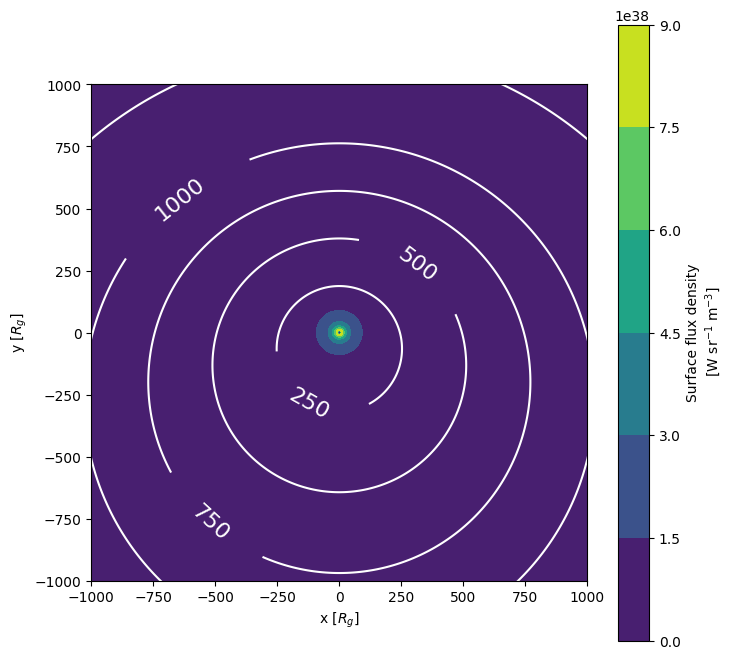

In [28]:
wavelength = 1000

flux_array = my_disk.calculate_surface_intensity_map(wavelength)

intensities = flux_array.flux_array


timelags = my_disk.calculate_time_lag_array()

contours = [250, 500, 750, 1000, 1500, 2000]

# zoom in
size = 1000

zoomaxis = np.linspace(-size, size, 2 * size)
X, Y = flux_array.get_plotting_axes()
Xzoom, Yzoom = np.meshgrid(zoomaxis, zoomaxis)


fig, ax = plt.subplots(figsize=(8, 8))

c1 = ax.contourf(
    X,
    Y,
    intensities,
)
td1 = ax.contour(
    X,
    Y,
    timelags,
    contours,
    colors="white",
)
plt.clabel(td1, inline=1, fontsize=16)

ax.set_aspect(1)
plt.colorbar(c1, ax=ax, label="Surface flux density\n " + r"[W sr$^{-1}$ m$^{-3}$]")
ax.set_xlabel(r"x [$R_{g}$]")
ax.set_ylabel(r"y [$R_{g}$]")
plt.subplots_adjust(wspace=0.5)
ax.set_xlim(-size, size)
ax.set_ylim(-size, size)
plt.show()

We see that the surface flux density is very localized within 250 gravitational radii. The time delay contours represent the time lag accrued between an assumed lamppost at 6 Rg above the SMBH. 

The methods calculate_db_dt_array, calculate_time_lag_array, and calculate_dt_dlx_array are more straight-forward ways to run the functions that construct the transfer function which we saw earlier. Arguments are fewer, as many are passed in directly from the initialization of the object. Many initialized values can still be overridden.

We can look at construct_accretion_disk_transfer_function next, which combines the above methods that were just glossed over. Arguments are:

observer_frame_wavelength_in_nm, the wavelength in the observers frame of reference in nanometers

corona_height, if a different lamp post is desired, this is the z position of the irradiating source.

axis_offset_in_gravitational_radii/angle_offset_in_degrees is the (r, phi) position of this irradiating source.

return_response_array_and_lags is a boolean to return the 2d distributions as opposed to the transfer function.

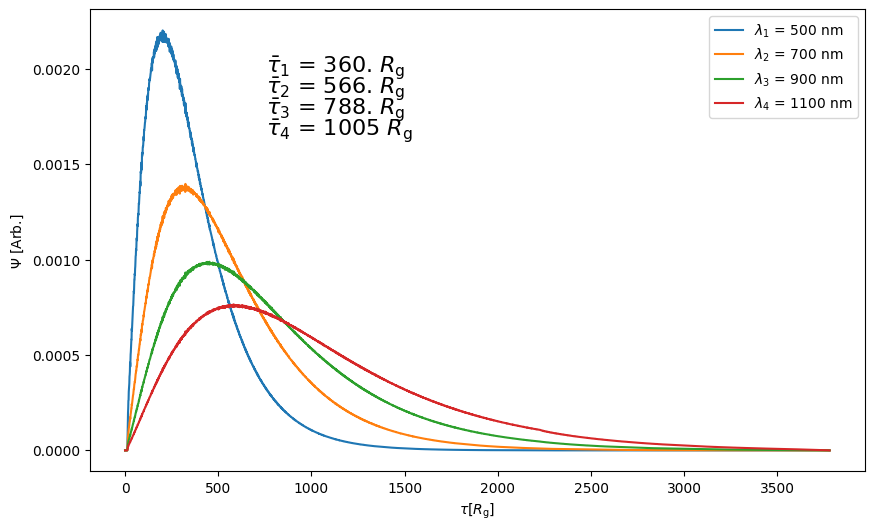

In [29]:
wavelen1 = 500
wavelen2 = 700
wavelen3 = 900
wavelen4 = 1100

transfer_function1 = my_disk.construct_accretion_disk_transfer_function(wavelen1)
transfer_function2 = my_disk.construct_accretion_disk_transfer_function(wavelen2)
transfer_function3 = my_disk.construct_accretion_disk_transfer_function(wavelen3)
transfer_function4 = my_disk.construct_accretion_disk_transfer_function(wavelen4)

mean1 = np.sum(
    np.linspace(0, len(transfer_function1), len(transfer_function1))
    * transfer_function1
)
mean2 = np.sum(
    np.linspace(0, len(transfer_function2), len(transfer_function2))
    * transfer_function2
)
mean3 = np.sum(
    np.linspace(0, len(transfer_function3), len(transfer_function3))
    * transfer_function3
)
mean4 = np.sum(
    np.linspace(0, len(transfer_function4), len(transfer_function4))
    * transfer_function4
)

fig, ax = plt.subplots(figsize=(10, 6))
ax.plot(transfer_function1, label=r"$\lambda_{1}$ = " + str(wavelen1) + " nm")
ax.plot(transfer_function2, label=r"$\lambda_{2}$ = " + str(wavelen2) + " nm")
ax.plot(transfer_function3, label=r"$\lambda_{3}$ = " + str(wavelen3) + " nm")
ax.plot(transfer_function4, label=r"$\lambda_{4}$ = " + str(wavelen4) + " nm")

ax.text(
    0.2 * len(transfer_function1),
    0.9 * np.max(transfer_function1),
    r"$\bar{\tau}_{1}$ = " + str(mean1)[:4] + r" $R_{\rm{g}}$",
    fontsize=16,
)
ax.text(
    0.2 * len(transfer_function1),
    0.85 * np.max(transfer_function1),
    r"$\bar{\tau}_{2}$ = " + str(mean2)[:4] + r" $R_{\rm{g}}$",
    fontsize=16,
)
ax.text(
    0.2 * len(transfer_function1),
    0.8 * np.max(transfer_function1),
    r"$\bar{\tau}_{3}$ = " + str(mean3)[:4] + r" $R_{\rm{g}}$",
    fontsize=16,
)
ax.text(
    0.2 * len(transfer_function1),
    0.75 * np.max(transfer_function1),
    r"$\bar{\tau}_{4}$ = " + str(mean4)[:4] + r" $R_{\rm{g}}$",
    fontsize=16,
)

ax.legend()
ax.set_xlabel(r"$\tau [R_{\rm{g}}]$")
ax.set_ylabel(r"$\Psi$ [Arb.]")

plt.show()

We have plotted the derived transfer functions for four wavelengths and reported the mean time delays.

Longer wavelengths will generally have wider transfer functions and therefore longer mean time lags as expected.

## Magnification Map

The MagnificationMap object is used to store and use a magnification map due to microlensing. In creating this object, the following arguments are needed:

redshift_source, the redshift of the source

redshift_lens, the redshift of the microlenses (which must be less than the redshift of the source)

magnification_array, the file which contains the magnification map. This can be a .fits file or a .dat, or a numpy array of values. If downloaded from the GERLUMPH database, it will come as a .dat file, which will be converted into a ray map of appropriate size. It's recommended to store this as a .fits file for future use to speed up the conversion process. Amoeba assumes this file will be ray counts per pixel, so a conversion to magnification will occur next.

convergence, the total convergence of the microlensing map (Kappa)

shear, the shear of the microlensing map (Gamma)

mean_microlens_mass_in_kg, the assumed average microlens mass in kg

total_microlens_einstein_radii, the number of Einstein radii along each side of the magnification map. A square map is assumed.

OmM, H0: the cosmological parameters of the flat LambdaCDM model

name, a name space


In [30]:
MagMap = MagnificationMap(0.1, 0.05, mag_map, 0.3, 0.3)

flux_projection_1 = my_disk.calculate_surface_intensity_map(400)

flux_projection_2 = my_disk.calculate_surface_intensity_map(800)

The magnification map of this object can be referenced directly by MagnificationMap.mag_map

The pixel size is stored as MagnificationMap.px_size



One primary method used will be convolve_with_flux_projection, which calculates the convolution of a flux distribution object with the magnification map. It takes the following arguments:

FluxProjection, the projected flux object generated from an AGN component.

relative_orientation, a degree rotation in the source plane.


This convolution can be stored in a new ConvolvedMap object to facilitate creating microlensing light curves

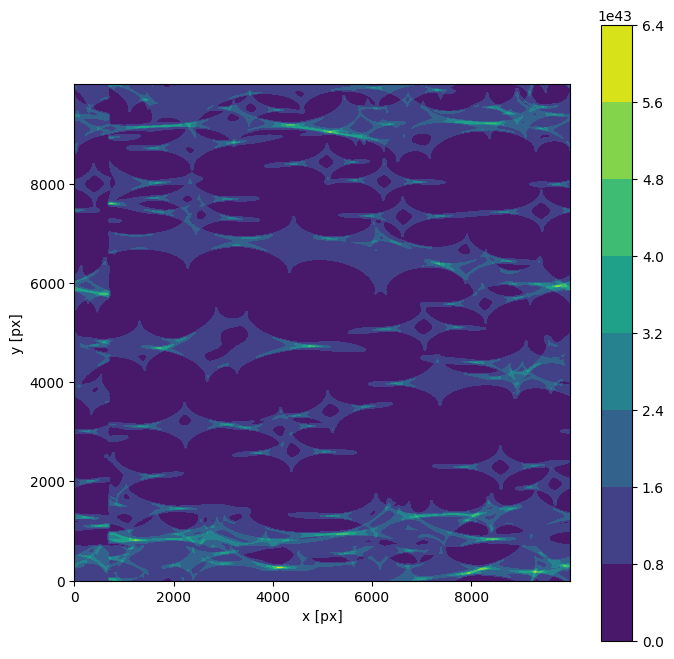

In [31]:
convolution_1 = MagMap.convolve_with_flux_projection(
    flux_projection_1, relative_orientation=0
)
convolution_2 = MagMap.convolve_with_flux_projection(
    flux_projection_2, relative_orientation=0
)


fig, ax = plt.subplots(figsize=(8, 8))

contours1 = ax.contourf(convolution_1.magnification_array)
plt.colorbar(contours1, ax=ax)
ax.set_aspect(1)
ax.set_xlabel(r"x [px]")
ax.set_ylabel(r"y [px]")
plt.show()

There is no notable difference between the two, however the pixel shift is stored within the ConvolvedMap. This value is inportant for accurately pulling light curves as it defines the SMBH location!

In [32]:
print(MagMap.pixel_shift)
print(convolution_1.pixel_shift)

0
696


However, this also means the convolved map is now locked at a certain observed wavelength. 

Light curves are generated using the pull_light_curve method. This has arguments:

effective_transverse_velocity, the transverse velocity in the source plane. This is expressed as km/s, where typical values range up to ~500 km/s. Some special cases like the Einstein Cross (Q2237+0305) may have significantly higher transverse velocities.

light_curve_duration_in_years, the length of the light curve measured in years

x_start_position, y_start_position: the starting position of the light curve in pixels. If left as None, a random starting point will be selected such that it will not cross into the convolution artifacts found near the edges.

phi_travel_direction, the direction of travel in the source plane measured in degrees

return_track_coords, a boolean to return the positions on the magnification map in pixels.

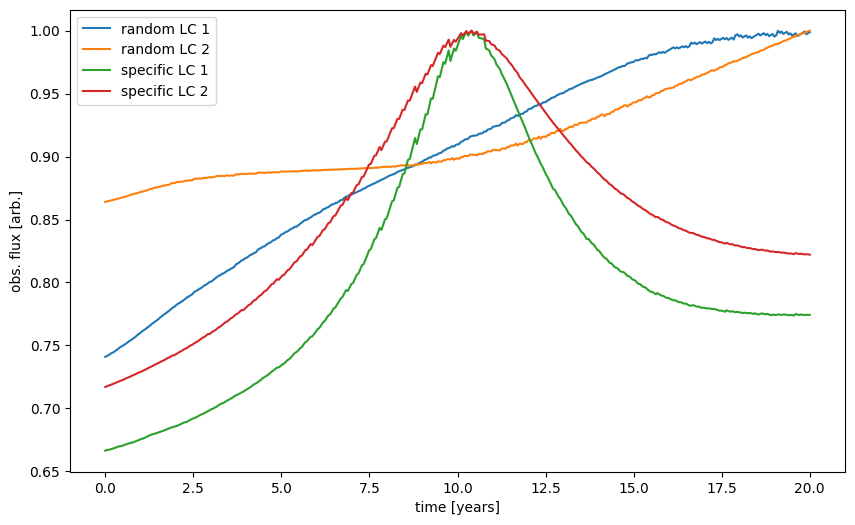

In [33]:
x = 3100  # pixels
y = 4200  # pixels
phi = 72  # degrees
vel = 400  # km/s
time = 20  # years

seed = 27

LC_specified_1 = convolution_1.pull_light_curve(
    vel, time, x_start_position=x, y_start_position=y, phi_travel_direction=phi
)

LC_specified_2 = convolution_2.pull_light_curve(
    vel, time, x_start_position=x, y_start_position=y, phi_travel_direction=phi
)

LC_random_1 = convolution_1.pull_light_curve(vel, time, random_seed=seed)
LC_random_2 = convolution_2.pull_light_curve(vel, time, random_seed=seed)

fig, ax = plt.subplots(figsize=(10, 6))
timeaxis = np.linspace(0, time, len(LC_random_1))

ax.plot(timeaxis, LC_random_1 / np.max(LC_random_1), label="random LC 1")
ax.plot(timeaxis, LC_random_2 / np.max(LC_random_2), label="random LC 2")

ax.plot(timeaxis, LC_specified_1 / np.max(LC_specified_1), label="specific LC 1")
ax.plot(timeaxis, LC_specified_2 / np.max(LC_specified_2), label="specific LC 2")

ax.set_xlabel("time [years]")
ax.set_ylabel("obs. flux [arb.]")
ax.legend()
plt.show()

The final method in the MagnificationMap object is calculate_microlensed_transfer_function, which should be called with the MagnificationMap object only and not the ConvolvedMap (else there will be a double convolution). This method computes a microlensed transfer function using the QMF function MicrolensedResponse as was done previously.

The GenerateMicrolensedResponse takes the following arguments:

AccretionDisk, the accretion disk object

observer_frame_wavelength_in_nm, the observed wavelength

corona_height, the z position of the flaring lamp post which the transfer function will be constructed with respect to. If left "None", this will keep the lamp post position of the accretion disk object. Modeling other sources of irradiation can be done as well.

relative_orientation, the degree rotation on the source plane. This is sometimes refered to as the position angle on the microlensing map.

x_position, y_position: the (x, y) coordinates in pixels on the magnification map. If left "None", this will randomly choose a spot which will remain fully on the magnification map, if possible.

axis_offset_in_gravitational_radii, angle_offset_in_degrees: the (r, phi) position of the flaring lamp post with respect to the accretion disk's axis of symmetry, in units $R_{\rm g}$ and degrees.

return_response_array_and_lags / return_descaled_response_array_and_lags, toggle to return the maps prior to calculating the transfer function

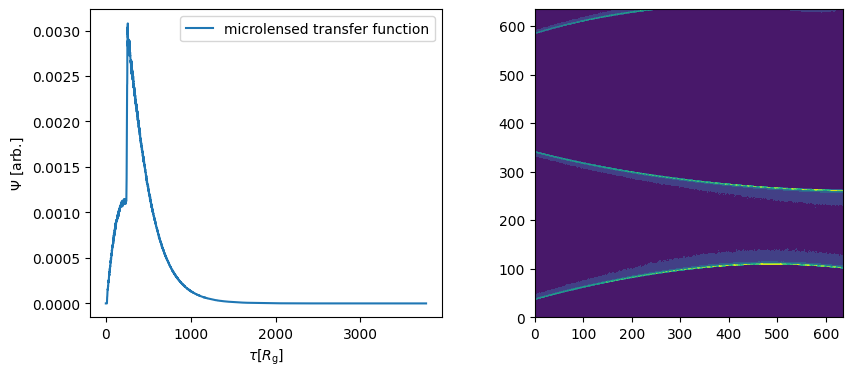

In [34]:
wavelength = 500
seednum = 9172107
np.random.seed(seednum)
TransferFunction = MagMap.calculate_microlensed_transfer_function(my_disk, wavelength, random_seed=seednum)
mag_region = MagMap.calculate_microlensed_transfer_function(my_disk, wavelength, return_magnification_map_crop=True, random_seed=seednum)

fig, ax = plt.subplots(1, 2, figsize=(10, 4))
ax[0].plot(TransferFunction, label="microlensed transfer function")
ax[0].set_xlabel(r"$\tau [R_{\rm{g}}]$")
ax[0].set_ylabel(r"$\Psi$ [arb.]")
ax[0].legend()
ax[1].contourf(mag_region)
ax[1].set_aspect(1)
plt.show()

In [35]:
meanTF = np.sum(
    np.linspace(0, len(TransferFunction), len(TransferFunction)) * TransferFunction
)
print(r"mean tau = " + str(meanTF)[:5] + " gravitational radii")

mean tau = 424.1 gravitational radii


This notebook will be extended as features are added, thank you for taking the time to try Amoeba out!

In [36]:
time_final = supertime.time()
print("Total time elapsed =", str(time_final - time_initial)[:6], "seconds")

Total time elapsed = 181.76 seconds
